In [1]:
import pandas as pd
# data = pd.read_excel(r"C:\Users\m1592\Desktop\日本agoda天产量.xlsx",index_col = u'channel_createdate')
# data = pd.read_excel(r"C:\Users\m1592\Desktop\日本一个月.xlsx",index_col = u'channel_createdate')
# data = pd.read_excel(r"C:\Users\m1592\Desktop\日本离店维度.xlsx",index_col = u'supplier_checkoutdate')
data = pd.read_excel(r"C:\Users\m1592\Desktop\离店维度全年.xlsx",index_col = u'supplier_checkoutdate')

data.head()

,count
supplier_checkoutdate,
2023-01-01,1481
2023-01-02,881
2023-01-03,877
2023-01-04,779
2023-01-05,701


In [63]:
data.tail()

,count
supplier_checkoutdate,
2023-10-11,551
2023-10-12,589
2023-10-13,675
2023-10-14,834
2023-10-15,1203


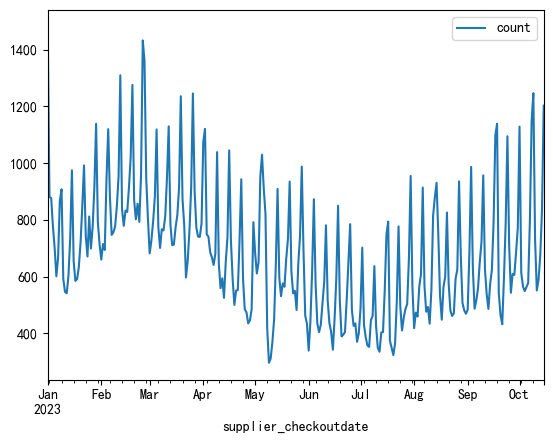

In [3]:
import matplotlib.pyplot as plt     
plt.rcParams['font.sans-serif'] = ['SimHei']    #定义使其正常显示中文字体黑体
plt.rcParams['axes.unicode_minus'] = False      #用来正常显示表示负号
data.plot()
plt.show()

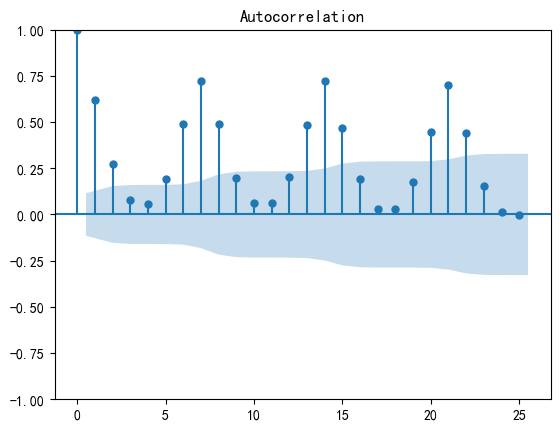

原始序列的检验结果为： (-1.157401433809869, 0.6916470402259899, 14, 273, {'1%': -3.45453261164607, '5%': -2.8721859575020017, '10%': -2.572442854861866}, 3314.8765279794666)


In [7]:
#画出自相关性图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data)
plt.show()
 
#平稳性检测
from statsmodels.tsa.stattools import adfuller
print('原始序列的检验结果为：',adfuller(data[u'count']))
#原始序列的检验结果为： (1.8137710150945268, 0.9983759421514264, 10, 26, {'1%': -3.7112123008648155,
#  '10%': -2.6300945562130176, '5%': -2.981246804733728}, 299.46989866024177)
#返回值依次为：adf, pvalue p值， usedlag, nobs, critical values临界值 , icbest, regresults, resstore 
#adf 分别大于3中不同检验水平的3个临界值，单位检测统计量对应的p 值显著大于 0.05 ， 说明序列可以判定为 非平稳序列

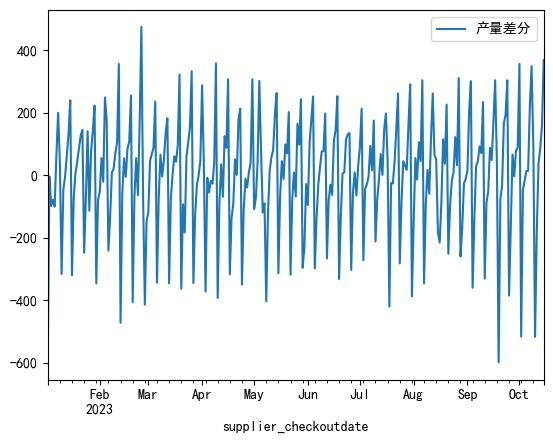

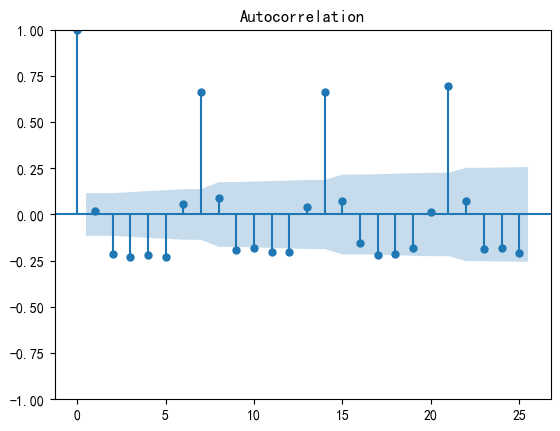

C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


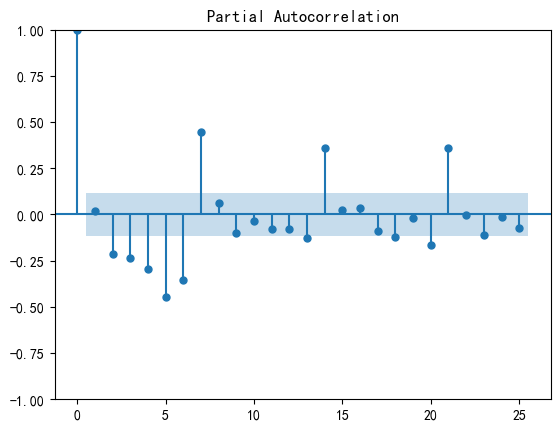

差分序列的ADF 检验结果为：  (-6.670546945248088, 4.599654755777953e-09, 13, 273, {'1%': -3.45453261164607, '5%': -2.8721859575020017, '10%': -2.572442854861866}, 3302.8862900321196)


In [8]:
#对数据进行差分后得到 自相关图和 偏相关图
D_data = data.diff().dropna()
# D_data = D_data1.diff().dropna()
D_data.columns = [u'产量差分']
 
D_data.plot()   #画出差分后的时序图
plt.show()
 
plot_acf(D_data)    #画出自相关图
plt.show()
plot_pacf(D_data)   #画出偏相关图
plt.show()
print(u'差分序列的ADF 检验结果为： ', adfuller(D_data[u'产量差分']))   #平稳性检验
#差分序列的ADF 检验结果为：  (-3.1560562366723537, 0.022673435440048798, 0, 35, {'1%': -3.6327426647230316, 
# '10%': -2.6130173469387756, '5%': -2.9485102040816327}, 287.5909090780334)
#一阶差分后的序列的时序图在均值附近比较平稳的波动， 自相关性有很强的短期相关性， 单位根检验 p值小于 0.05 ，所以说一阶差分后的序列是平稳序列

In [9]:
#对一阶差分后的序列做白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果：',acorr_ljungbox(D_data, lags= 16)) #返回统计量和 p 值
# 差分序列的白噪声检验结果： (array([11.30402222]), array([0.00077339])) p值为第二项， 远小于 0.05

差分序列的白噪声检验结果：        lb_stat     lb_pvalue
1     0.076074  7.826901e-01
2    13.078086  1.445871e-03
3    28.719578  2.564798e-06
4    42.494660  1.317285e-08
5    58.278143  2.756120e-11
6    59.218568  6.486210e-11
7   189.748395  1.696003e-37
8   192.250554  2.737205e-37
9   203.308395  6.706550e-39
10  213.007366  3.102763e-40
11  225.137567  4.386077e-42
12  237.720886  4.943914e-44
13  238.267434  1.738606e-43
14  371.455543  1.286958e-70
15  372.970517  3.257311e-70
16  380.347591  4.746703e-71


In [21]:
import statsmodels.api as sm
import warnings

In [68]:
#对模型进行定阶
import statsmodels.api as sm
import warnings
pmax = int(len(D_data) / 10)    #一般阶数不超过 length /10
qmax = int(len(D_data) / 10)
# pmax = 10
# qmax = 10
bic_matrix = []
warnings.filterwarnings("ignore")
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(sm.tsa.ARIMA(data, order = (p, 1, q)).fit().bic)
        except:
            temp.append(None)
        bic_matrix.append(temp)
 
bic_matrix = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
p,q = bic_matrix.stack().astype('float').idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1

BIC 最小的p值 和 q 值：174,8


In [19]:
#对模型进行定阶
import statsmodels.api as sm
pmax = int(len(D_data) / 10)    #一般阶数不超过 length /10
qmax = int(len(D_data) / 10)
# pmax = 10
# qmax = 10
aic_matrix = []
warnings.filterwarnings("ignore")
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(sm.tsa.ARIMA(data, order = (p, 1, q)).fit().aic)
        except:
            temp.append(None)
        aic_matrix.append(temp)
 
aic_matrix = pd.DataFrame(aic_matrix)   #将其转换成Dataframe 数据结构
p,q = aic_matrix.stack().astype('float').idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1

BIC 最小的p值 和 q 值：70,4


In [69]:
import statsmodels.api as sm
warnings.filterwarnings("ignore")
# model = sm.tsa.ARIMA(data, order = (28,2,4)).fit()
# model = sm.tsa.ARIMA(data, order = (84,2,9)).fit()
model = sm.tsa.ARIMA(data, order = (174,1,8)).fit()

model.summary()        #生成一份模型报告
model.forecast(5)   #为未来5天进行预测，返回预测结果、标准误差和置信区间

2023-10-16    1005.662973
2023-10-17     806.148212
2023-10-18     807.151555
2023-10-19     909.305247
2023-10-20     924.348759
Freq: D, Name: predicted_mean, dtype: float64

In [75]:
resid = model.resid
print('残差序列的白噪声检验结果为：',acorr_ljungbox(resid,lags=1))

残差序列的白噪声检验结果为：     lb_stat  lb_pvalue
1  2.537203   0.111192


In [76]:
model.forecast(steps = 10, exog = None, alpha = 0.05)

2023-10-16    1005.662973
2023-10-17     806.148212
2023-10-18     807.151555
2023-10-19     909.305247
2023-10-20     924.348759
2023-10-21    1073.678161
2023-10-22    1218.959578
2023-10-23     961.742539
2023-10-24     844.656706
2023-10-25     790.658057
Freq: D, Name: predicted_mean, dtype: float64

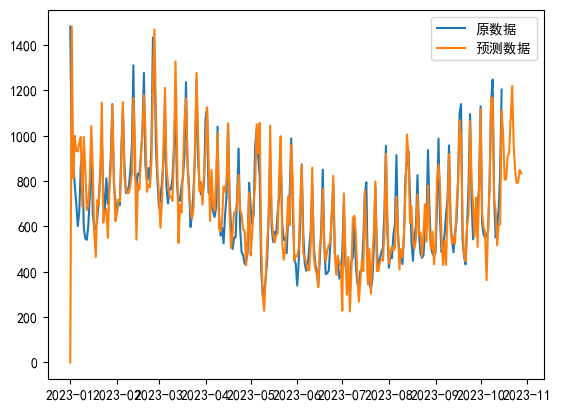

In [74]:
predict_data = model.predict(0,300)
plt.plot(data,label = '原数据')
plt.plot(predict_data, label = '预测数据')
plt.legend()
plt.show()

In [77]:
#判断数据集是否存在季节性
result = sm.tsa.seasonal_decompose(data)
if result.trend is not None:
    print("该时间序列存在趋势")
if result.seasonal is not None:
    print("该时间序列存在季节性")

该时间序列存在趋势
该时间序列存在季节性


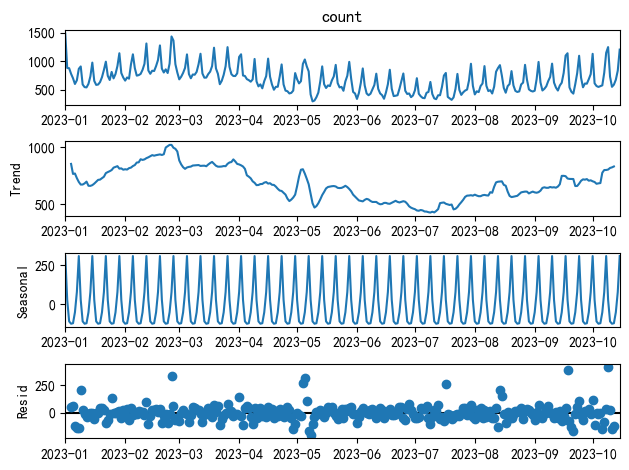

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_decomposition = seasonal_decompose(data['count'])
ts_decomposition.plot()
plt.show()

In [10]:
def stableCheck(timeseries):
    #移动7期的均值和方差
    rol_mean = timeseries.rolling(window=7).mean()
    rol_std = timeseries.rolling(window=7).std()
    #绘图
    fig  = plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rol_mean,color='red',label='Rolling Mean')
    std = plt.plot(rol_std,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    #进行ADF检验
    print('Results of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries, autolag='AIC')
    #对检验结果进行语义描述
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        print('ADF检验结果: ')
        print(dfoutput)

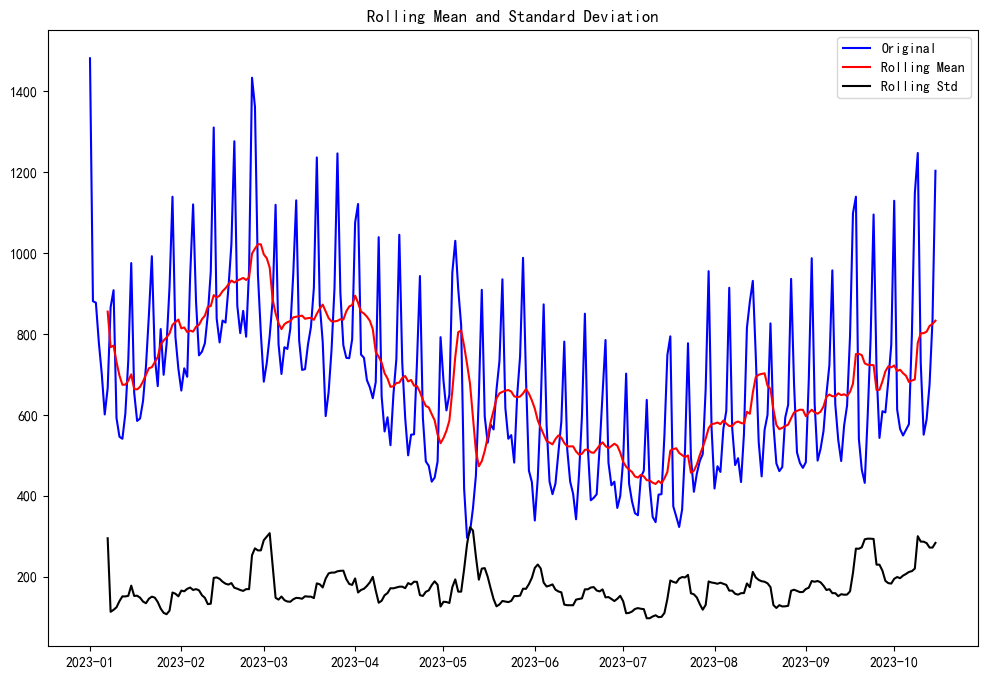

Results of Dickey-Fuller Test: 
ADF检验结果: 
Test Statistic                  -1.157401
p-value                          0.691647
#Lags Used                      14.000000
Number of Observations Used    273.000000
Critical Value (1%)             -3.454533
dtype: float64
ADF检验结果: 
Test Statistic                  -1.157401
p-value                          0.691647
#Lags Used                      14.000000
Number of Observations Used    273.000000
Critical Value (1%)             -3.454533
Critical Value (5%)             -2.872186
dtype: float64
ADF检验结果: 
Test Statistic                  -1.157401
p-value                          0.691647
#Lags Used                      14.000000
Number of Observations Used    273.000000
Critical Value (1%)             -3.454533
Critical Value (5%)             -2.872186
Critical Value (10%)            -2.572443
dtype: float64


In [11]:
stableCheck_result = stableCheck(data)

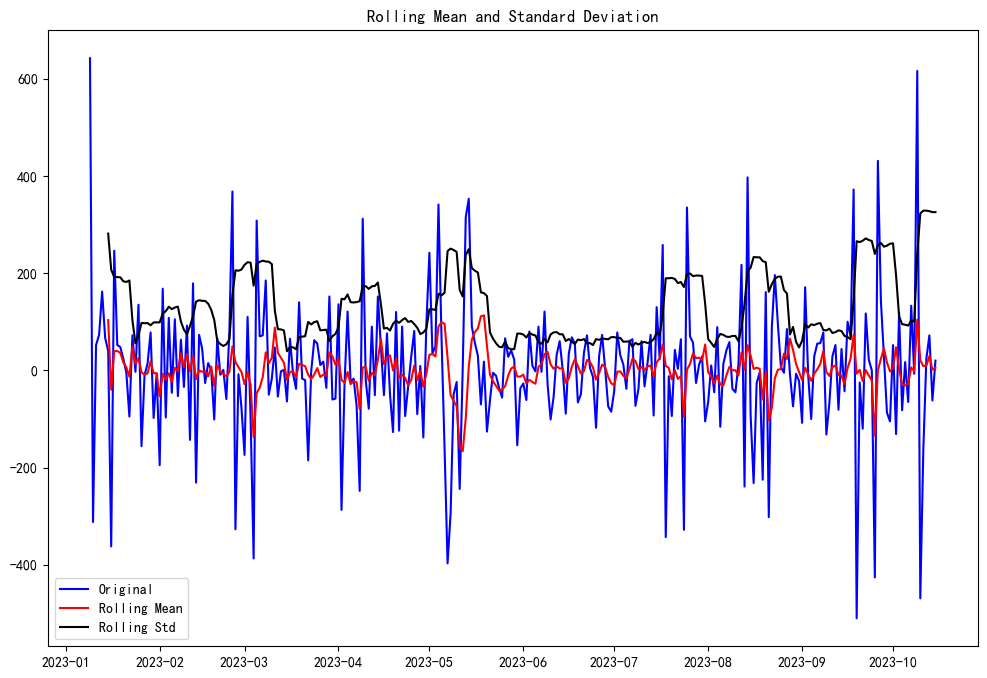

Results of Dickey-Fuller Test: 
ADF检验结果: 
Test Statistic                -9.019388e+00
p-value                        5.830966e-15
#Lags Used                     1.400000e+01
Number of Observations Used    2.650000e+02
Critical Value (1%)           -3.455270e+00
dtype: float64
ADF检验结果: 
Test Statistic                -9.019388e+00
p-value                        5.830966e-15
#Lags Used                     1.400000e+01
Number of Observations Used    2.650000e+02
Critical Value (1%)           -3.455270e+00
Critical Value (5%)           -2.872509e+00
dtype: float64
ADF检验结果: 
Test Statistic                -9.019388e+00
p-value                        5.830966e-15
#Lags Used                     1.400000e+01
Number of Observations Used    2.650000e+02
Critical Value (1%)           -3.455270e+00
Critical Value (5%)           -2.872509e+00
Critical Value (10%)          -2.572615e+00
dtype: float64


In [12]:
# 差分处理非平稳序列，先进行一阶差分
D_data1 = data.diff(1).dropna()
# 在一阶差分基础上进行季节性差分
D_data2 = D_data.diff(7).dropna()
stableCheck_result2 = stableCheck(D_data2)

In [13]:
def whiteNoiseCheck(h_data):
    result = acorr_ljungbox(h_data,lags = 1)
    temp = result[1]
    print('白噪声检测结果: ', result)
    print(temp)
    return result 

In [14]:
#temp小于0.05，则认为序列为非白噪声序列
# ifwhiteNoise = whiteNoiseCheck(D_data2)
# from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果：',acorr_ljungbox(D_data2, lags= 5))

差分序列的白噪声检验结果：      lb_stat  lb_pvalue
1  16.710555   0.000044
2  16.711453   0.000235
3  19.011394   0.000272
4  19.045583   0.000770
5  19.810902   0.001356


In [15]:
def draw_acf(data):
    plot_acf(data)
    plt.title("序列自相关图（ACF）")
    plt.show()

def draw_pacf(data):
    plot_pacf(data)
    plt.title("序列偏自相关图（PACF）")
    plt.show()

# def draw_acf_pacf(data):
#     f = plt.figure(facecolor='white')
#     ax1 = f.add_subplot(211)
    

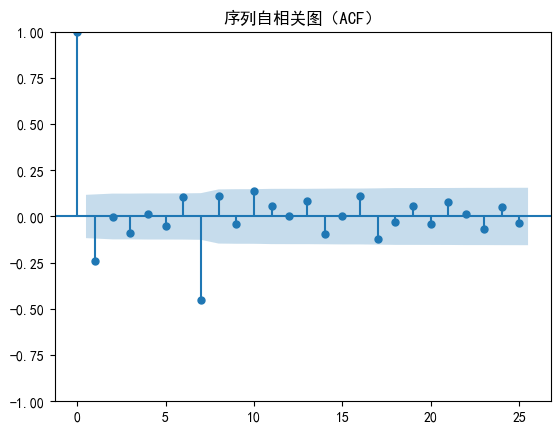

In [16]:
draw_acf(D_data2)

C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


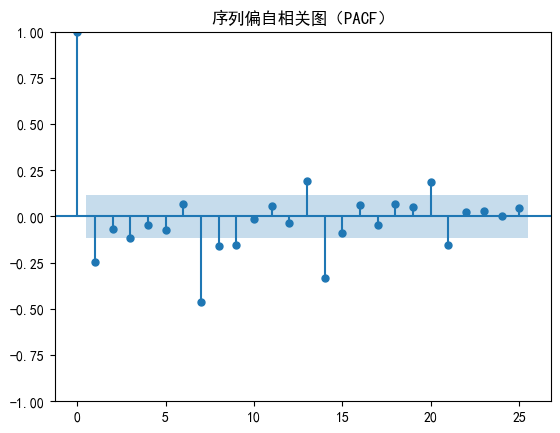

In [17]:
draw_pacf(D_data2)

In [22]:
#利用BIC准则找最优的参数
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from itertools import product 


In [128]:
from itertools import product 
ps = range(0,4,1)
# ps = range(0,4)
d = [1]
# d = 1
# qs = range(0,7)
qs = range(0,4,1)
Ps = range(0,4,1)
D = [1]
# D = 1
Qs = range(0,4,1)
params_list = list(product(ps,d,qs,Ps,D,Qs))
print(params_list)

[(0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 1, 1), (0, 1, 0, 0, 1, 2), (0, 1, 0, 0, 1, 3), (0, 1, 0, 1, 1, 0), (0, 1, 0, 1, 1, 1), (0, 1, 0, 1, 1, 2), (0, 1, 0, 1, 1, 3), (0, 1, 0, 2, 1, 0), (0, 1, 0, 2, 1, 1), (0, 1, 0, 2, 1, 2), (0, 1, 0, 2, 1, 3), (0, 1, 0, 3, 1, 0), (0, 1, 0, 3, 1, 1), (0, 1, 0, 3, 1, 2), (0, 1, 0, 3, 1, 3), (0, 1, 1, 0, 1, 0), (0, 1, 1, 0, 1, 1), (0, 1, 1, 0, 1, 2), (0, 1, 1, 0, 1, 3), (0, 1, 1, 1, 1, 0), (0, 1, 1, 1, 1, 1), (0, 1, 1, 1, 1, 2), (0, 1, 1, 1, 1, 3), (0, 1, 1, 2, 1, 0), (0, 1, 1, 2, 1, 1), (0, 1, 1, 2, 1, 2), (0, 1, 1, 2, 1, 3), (0, 1, 1, 3, 1, 0), (0, 1, 1, 3, 1, 1), (0, 1, 1, 3, 1, 2), (0, 1, 1, 3, 1, 3), (0, 1, 2, 0, 1, 0), (0, 1, 2, 0, 1, 1), (0, 1, 2, 0, 1, 2), (0, 1, 2, 0, 1, 3), (0, 1, 2, 1, 1, 0), (0, 1, 2, 1, 1, 1), (0, 1, 2, 1, 1, 2), (0, 1, 2, 1, 1, 3), (0, 1, 2, 2, 1, 0), (0, 1, 2, 2, 1, 1), (0, 1, 2, 2, 1, 2), (0, 1, 2, 2, 1, 3), (0, 1, 2, 3, 1, 0), (0, 1, 2, 3, 1, 1), (0, 1, 2, 3, 1, 2), (0, 1, 2, 3, 1, 3), (0, 1, 3, 0, 1, 0), (0, 1, 3, 0, 1, 1),

In [129]:
warnings.filterwarnings("ignore")
def find_best_params(data:np.array, params_list):
    result = []
    best_bic = 100000
    for param in tqdm_notebook(params_list):
        model = SARIMAX(data, order=(param[0],param[1],param[2]), seasonal_order=(param[3],param[4],param[5],7)).fit(disp=-1)
        bicc = model.bic
        if bicc < best_bic:
            best_mode = model
            best_bic = bicc
            best_param = param
        param_1 = (param[0],param[1],param[2])
        param_2 = (param[3],param[4],param[5],7)
        param = 'SARIMA{0}x{1}'.format(param_1,param_2)
        print(param)
        result.append([param, model.bic])
        
    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters','bic']
    result_table = result_table.sort_values(by='bic',ascending=True).reset_index(drop=True)
    return result_table

result_table = find_best_params(data, params_list)
print(result_table)

  0%|          | 0/256 [00:00<?, ?it/s]

SARIMA(0, 1, 0)x(0, 1, 0, 7)
SARIMA(0, 1, 0)x(0, 1, 1, 7)
SARIMA(0, 1, 0)x(0, 1, 2, 7)
SARIMA(0, 1, 0)x(0, 1, 3, 7)
SARIMA(0, 1, 0)x(1, 1, 0, 7)
SARIMA(0, 1, 0)x(1, 1, 1, 7)
SARIMA(0, 1, 0)x(1, 1, 2, 7)
SARIMA(0, 1, 0)x(1, 1, 3, 7)
SARIMA(0, 1, 0)x(2, 1, 0, 7)
SARIMA(0, 1, 0)x(2, 1, 1, 7)
SARIMA(0, 1, 0)x(2, 1, 2, 7)
SARIMA(0, 1, 0)x(2, 1, 3, 7)
SARIMA(0, 1, 0)x(3, 1, 0, 7)
SARIMA(0, 1, 0)x(3, 1, 1, 7)
SARIMA(0, 1, 0)x(3, 1, 2, 7)
SARIMA(0, 1, 0)x(3, 1, 3, 7)
SARIMA(0, 1, 1)x(0, 1, 0, 7)
SARIMA(0, 1, 1)x(0, 1, 1, 7)
SARIMA(0, 1, 1)x(0, 1, 2, 7)
SARIMA(0, 1, 1)x(0, 1, 3, 7)
SARIMA(0, 1, 1)x(1, 1, 0, 7)
SARIMA(0, 1, 1)x(1, 1, 1, 7)
SARIMA(0, 1, 1)x(1, 1, 2, 7)
SARIMA(0, 1, 1)x(1, 1, 3, 7)
SARIMA(0, 1, 1)x(2, 1, 0, 7)
SARIMA(0, 1, 1)x(2, 1, 1, 7)
SARIMA(0, 1, 1)x(2, 1, 2, 7)
SARIMA(0, 1, 1)x(2, 1, 3, 7)
SARIMA(0, 1, 1)x(3, 1, 0, 7)
SARIMA(0, 1, 1)x(3, 1, 1, 7)
SARIMA(0, 1, 1)x(3, 1, 2, 7)
SARIMA(0, 1, 1)x(3, 1, 3, 7)
SARIMA(0, 1, 2)x(0, 1, 0, 7)
SARIMA(0, 1, 2)x(0, 1, 1, 7)
SARIMA(0, 1, 2

LinAlgError: LU decomposition error.

In [19]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    results = []
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(exog, order=(param[0],d,param[1]),seasonal_order=([param[2],D,param[3],s])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        results.append([param,aic])
    
    result_df =pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)','AIC']
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [23]:
p = range(0,7,1)
d = 1
q = range(0,7,1)
P = range(0,7,1)
D = 1
Q = range(0,7,1)
s = 7
parameters = product(p,q,P,Q)
parameters_list = list(parameters)
print(len(parameters_list))

2401


In [24]:
warnings.filterwarnings("ignore")
result_df = optimize_SARIMA(parameters_list,1,1,7,data)
result_df

C:\Users\m1592\AppData\Local\Temp\ipykernel_22192\1043972968.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/2401 [00:00<?, ?it/s]

C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

,"(p,q)x(P,Q)",AIC
0,"(3, 0, 1, 3)",16.000000
1,"(1, 1, 3, 2)",16.000000
2,"(3, 2, 5, 0)",22.000000
3,"(4, 4, 2, 1)",24.000000
4,"(3, 4, 2, 2)",24.000000
...,...,...
2354,"(4, 0, 0, 0)",3567.761655
2355,"(5, 0, 0, 0)",3567.809494
2356,"(2, 0, 0, 0)",3568.239677
2357,"(6, 0, 0, 0)",3568.582942


In [34]:
ma1 = SARIMAX(data, order=(1,1,3),seasonal_order=(0,1,1,7)).fit(disp=-1)
resid = ma1.resid
print(acorr_ljungbox(resid, lags=6))

C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


     lb_stat  lb_pvalue
1  11.660337   0.000638
2  12.067604   0.002396
3  12.087839   0.007088
4  12.089486   0.016698
5  13.293857   0.020775
6  16.289771   0.012280


C:\Users\m1592\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               count   No. Observations:                  288
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 7)   Log Likelihood               -1678.345
Date:                             Mon, 23 Oct 2023   AIC                           3368.690
Time:                                     10:44:00   BIC                           3390.498
Sample:                                 01-01-2023   HQIC                          3377.437
                                      - 10-15-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4768      0.175      2.720      0.007       0.133       0.820
ma.L1         -0.8626      0.179     -4.816      0.000      -1.214      -0.512
ma.L2          0.0559      0.086      0.654      0.513      -0.112       0.224
ma.L3         -0.0941      0.100     -0.940      0.347      -0.290       0.102
ma.S.L7       -0.9032      0.040    -22.717      0.000      -0.981      -0.825
sigma2      8846.7800    397.222     22.272      0.000    8068.238    9625.322
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):               338.26
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             1.07
Prob(H) (two-sided):                  0.22   Kurtosis:                         7.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

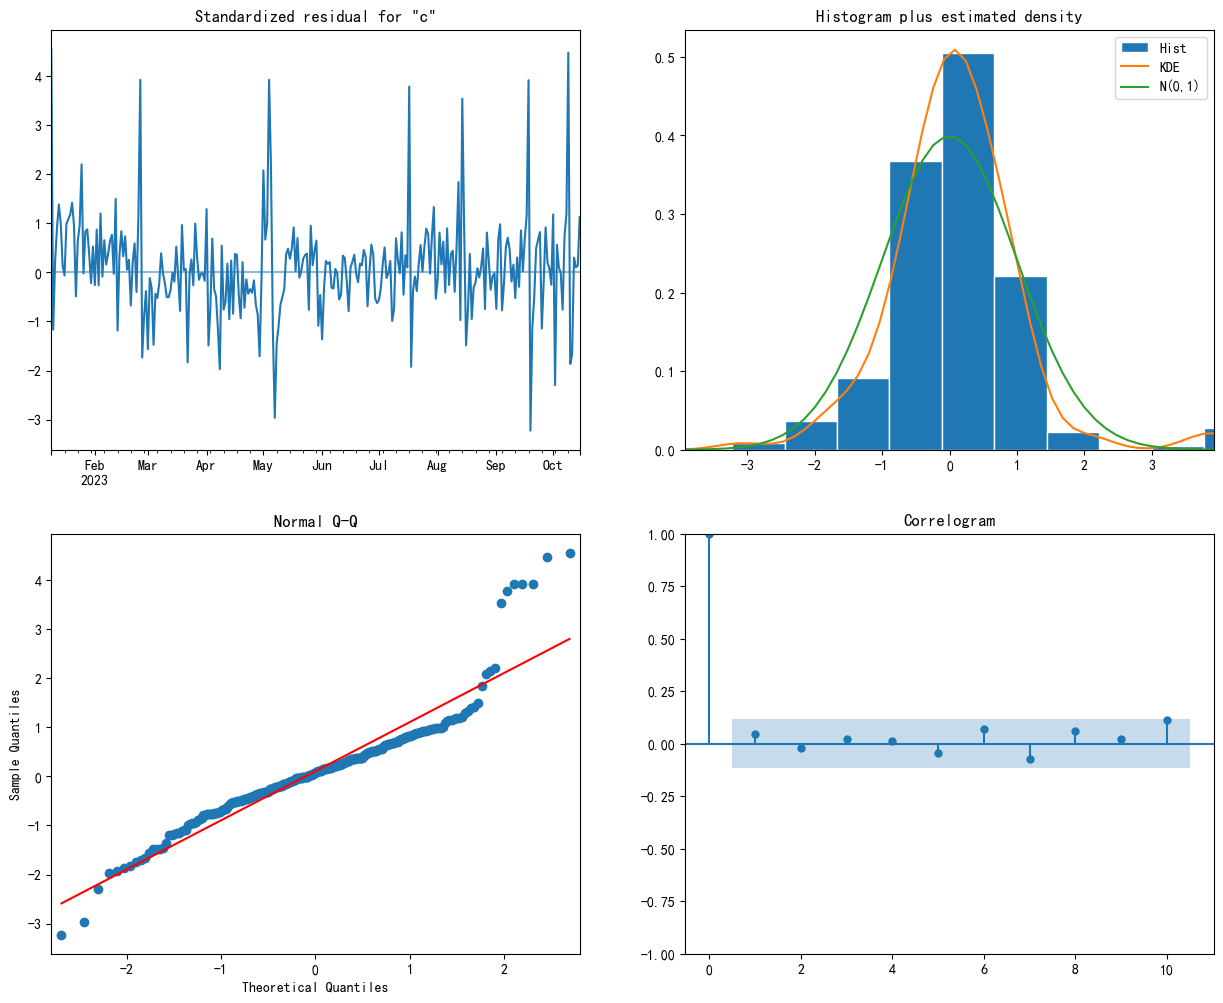

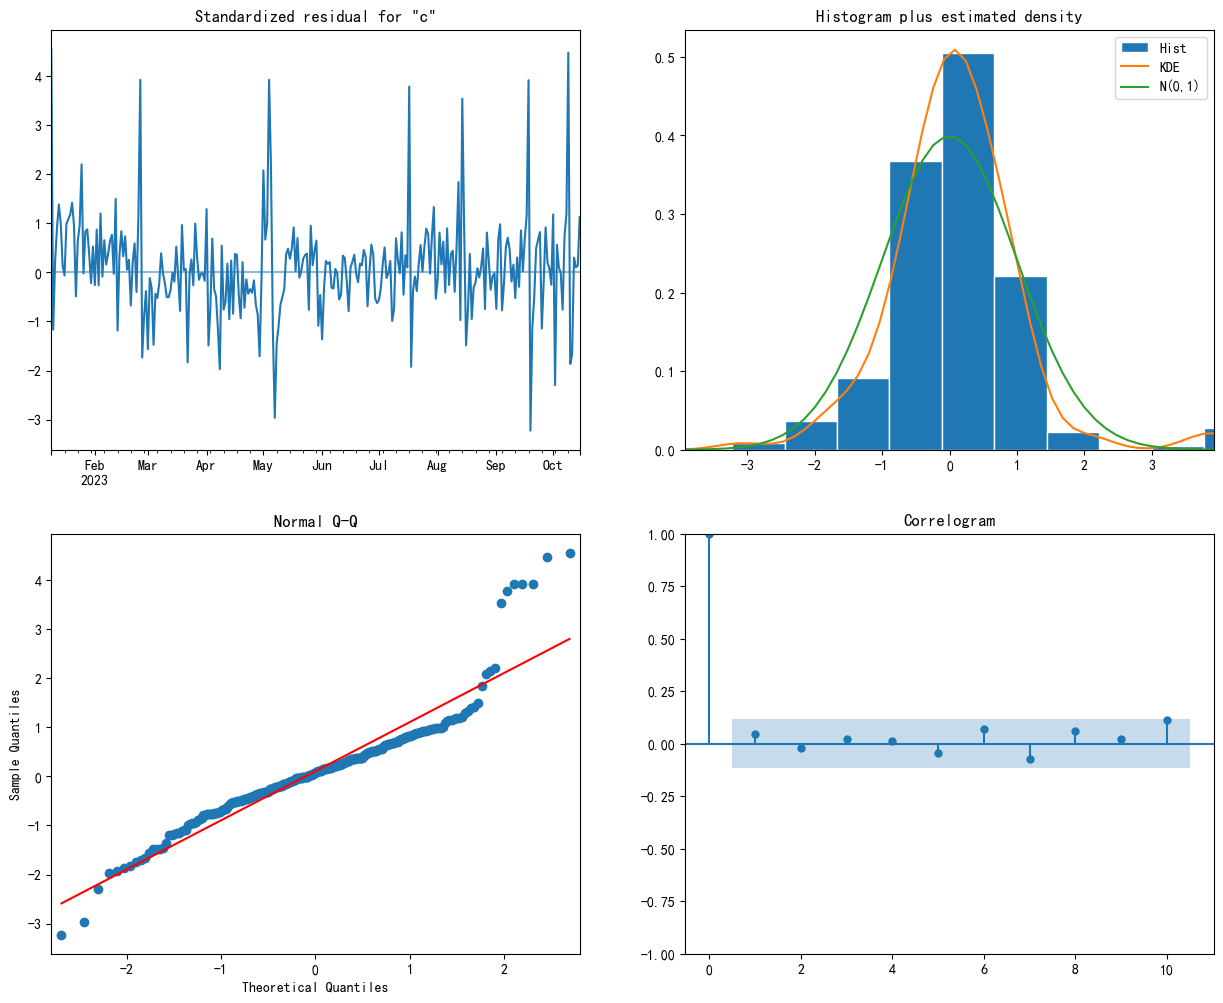

In [37]:
ma1.plot_diagnostics(figsize=(15,12))

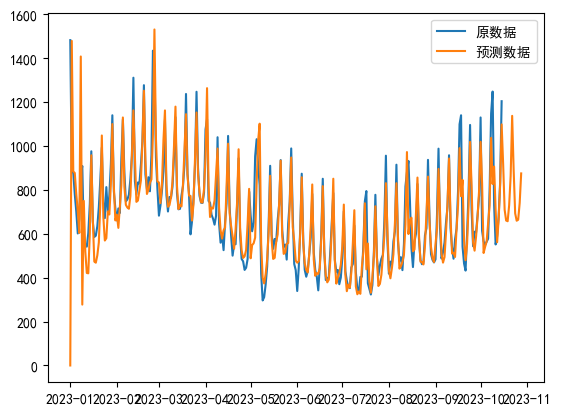

In [49]:
predict_data = ma1.predict(0,300)
plt.plot(data,label = '原数据')
plt.plot(predict_data, label = '预测数据')
plt.legend()
plt.show()

In [ ]:
[forData,YMSE] = forecast(EstMdl,step,data)   #matlab2018及以下版本写为Predict_Y = forecast(EstMdl,step,'Y0',Y);   matlab2019写为Predict_Y = forecast(EstMdl,step,Y);

lower = forData - 1.96*sqrt(YMSE); #95置信区间下限
upper = forData + 1.96*sqrt(YMSE); #95置信区间上限

figure('Visible','on')
plot(data,'Color',[.7,.7,.7]);
hold on
h1 = plot(length(data):length(data)+step,[data(end);lower],'r:','LineWidth',2);
plot(length(data):length(data)+step,[data(end);upper],'r:','LineWidth',2)
h2 = plot(length(data):length(data)+step,[data(end);forData],'k','LineWidth',2);
legend([h1 h2],'95% 置信区间','预测值',...
	     'Location','NorthWest')
title('Forecast')
hold off

In [44]:
ma1.forecast(steps = 10, exog = None, alpha = 0.05)

2023-10-16     917.973011
2023-10-17     708.814046
2023-10-18     659.884872
2023-10-19     656.727143
2023-10-20     729.270693
2023-10-21     862.722842
2023-10-22    1136.395666
2023-10-23     888.337636
2023-10-24     692.594144
2023-10-25     659.031273
Freq: D, Name: predicted_mean, dtype: float64